# Model evaluation using Sidekick
In this notebook you will learn how to use the Deployment API of the Peltarion platform via Sidekick to get predictions on samples and evaluate the performance of the deployed model in more detail.

Note: This notebook requires installation of Sidekick. For more information about this package, see:
https://github.com/Peltarion/sidekick

In [1]:
from IPython.display import display, Image
import os
import time
import sidekick
import resource
import itertools
import numpy as np
import pandas as pd
from PIL import Image
from sklearn import metrics
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Getting predictions

In [11]:
client = sidekick.Deployment(
    # Enter URL and token
    url='...',
    token='...',
    dtypes_in={'image': 'Image (300x300x3)'},
    dtypes_out={'prob': 'Float (1)'}
)

#preprocessed dataset
dataset_path = 'preprocessed'

In [12]:
df = pd.read_csv(os.path.join(dataset_path, 'index.csv'))
df = df.sample(frac=1, random_state=2323)
df.head()

,image,prob,type,subset,prob_binary
3094,images/cell1420.png,1.000000,mono,T,1
2238,images/cell0240.png,0.333333,poly,V,1
1178,images/cell0424.png,1.000000,mono,T,1
3173,images/cell0201.png,1.000000,poly,V,1
2110,images/cell2496.png,0.000000,poly,V,0


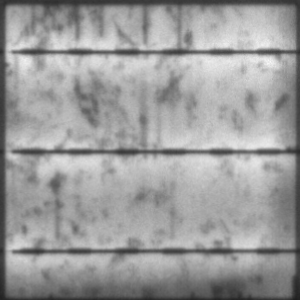

In [13]:
img = Image.open(os.path.join(dataset_path,'images/cell2021.png'))
display(img)

In [14]:
client.predict(image=img)

{'prob': 0.3611031}

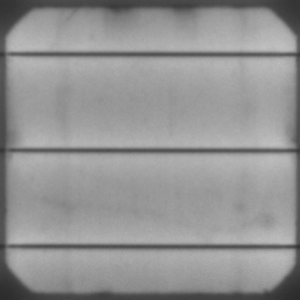

Ground truth: 1.0, Prediction: 0.9826816


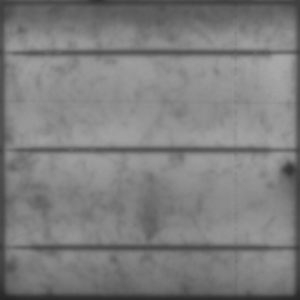

Ground truth: 0.3333333333333333, Prediction: 0.2811646


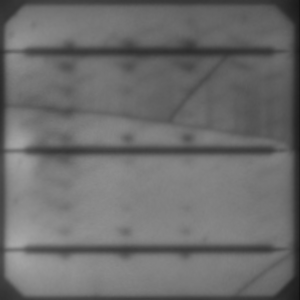

Ground truth: 1.0, Prediction: 0.976253


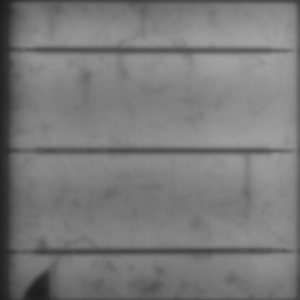

Ground truth: 1.0, Prediction: 0.4679377


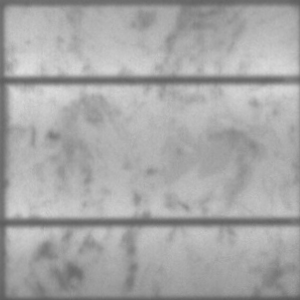

Ground truth: 0.0, Prediction: -0.011045162


In [6]:
first_rows = df.head()
for i, row in first_rows.iterrows():
    img = Image.open(os.path.join(dataset_path, row['image']))
    display(img)
    time.sleep(1)
    pred = client.predict(image=img)
    print('Ground truth: {}, Prediction: {}'.format(row['prob'], pred['prob']))

## Getting predictions (batch)

### Filter out training data

In [52]:
# Validation data
val = df[df['subset']=='V']

### Increase number of file handles

In [53]:
soft, hard = resource.getrlimit(resource.RLIMIT_NOFILE)
print('Soft: ' + str(soft) + ' Hard: ' + str(hard))
resource.setrlimit(resource.RLIMIT_NOFILE, (2000, hard))

Soft: 2000 Hard: 9223372036854775807


### Batch request

In [54]:
val['image_url'] = val['image']
val['image'] = val['image'].apply(
        lambda path: Image.open(os.path.join(dataset_path, path)))
predictions = client.predict_lazy(val.to_dict('record'))

In [55]:
#This may take several minutes...
preds = [p for p in predictions]
val['pred'] = [p['prob'] for p in preds]
eval_df = val[['image','image_url','pred', 'prob', 'prob_binary']]
eval_df.head(10)

,image,image_url,pred,prob,prob_binary
2238,<PIL.PngImagePlugin.PngImageFile image mode=RG...,images/cell0240.png,0.281165,0.333333,1
3173,<PIL.PngImagePlugin.PngImageFile image mode=RG...,images/cell0201.png,0.467938,1.000000,1
2110,<PIL.PngImagePlugin.PngImageFile image mode=RG...,images/cell2496.png,-0.011045,0.000000,0
2343,<PIL.PngImagePlugin.PngImageFile image mode=RG...,images/cell1495.png,0.050818,0.000000,0
2100,<PIL.PngImagePlugin.PngImageFile image mode=RG...,images/cell2357.png,0.039594,0.000000,0
2307,<PIL.PngImagePlugin.PngImageFile image mode=RG...,images/cell0863.png,0.993151,1.000000,1
2051,<PIL.PngImagePlugin.PngImageFile image mode=RG...,images/cell2118.png,-0.015387,0.000000,0
2392,<PIL.PngImagePlugin.PngImageFile image mode=RG...,images/cell2455.png,-0.031968,0.000000,0
1980,<PIL.PngImagePlugin.PngImageFile image mode=RG...,images/cell0416.png,0.937236,1.000000,1
2586,<PIL.PngImagePlugin.PngImageFile image mode=RG...,images/cell1203.png,0.025837,0.000000,0


## Evaluation

In [56]:
(round(eval_df['pred'])==eval_df['prob_binary']).sum() / len(eval_df)

0.895808383233533

In [57]:
mse = mean_squared_error(eval_df['pred'], eval_df['prob'])
mae = mean_absolute_error(eval_df['pred'], eval_df['prob'])
evs = explained_variance_score(eval_df['pred'], eval_df['prob'])
print('Mean squared error: %f\nMean absolute error: %f\nexplained variance score: %f' % (mse,mae,evs))

Mean squared error: 0.013601
Mean absolute error: 0.052059
explained variance score: 0.938464


In [58]:
def plot_roc_curve(df):
    y_true = df['prob_binary']
    y_prob = df['pred']
    fpr, tpr, thresholds_roc = metrics.roc_curve(y_true=y_true, y_score=y_prob)
    auc = metrics.auc(fpr, tpr)
    
    f, ax = plt.subplots(1, 1, figsize = (9,9));
    plt.plot(fpr, tpr)
    ax.set_xlabel('False positive rate / 1 - Specificity', fontsize=16)
    ax.set_ylabel('True positive rate / Sensitivity / Recall', fontsize=16)
    ax.set_title(f'ROC curve, AUC {round(auc, ndigits=2)}', fontsize=20)
    plt.show()

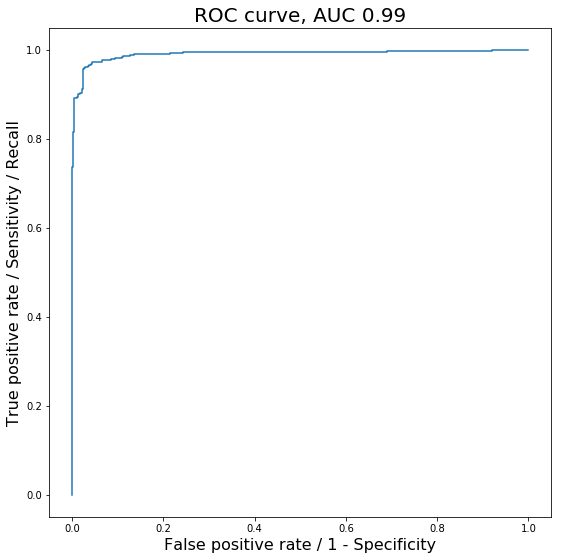

In [20]:
plot_roc_curve(eval_df)

In [17]:
cnf_mx = confusion_matrix(y_true=round(eval_df['prob_binary']), y_pred=round(eval_df['pred']))

In [18]:
print(classification_report(y_true=round(eval_df['prob']), y_pred=round(eval_df['pred'])))

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       451
         1.0       0.99      0.96      0.98       384

   micro avg       0.98      0.98      0.98       835
   macro avg       0.98      0.98      0.98       835
weighted avg       0.98      0.98      0.98       835



In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[376   1]
 [ 86 372]]


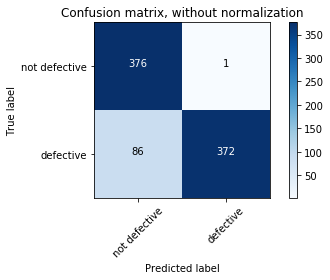

In [20]:
plt.figure()
plot_confusion_matrix(cnf_mx, classes=['not defective', 'defective'],
                      title='Confusion matrix, without normalization')

Normalized confusion matrix
[[0.99734748 0.00265252]
 [0.18777293 0.81222707]]


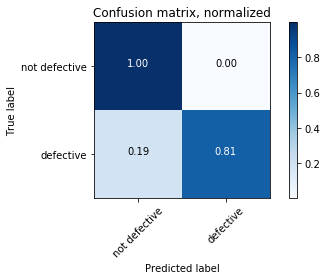

In [21]:
plt.figure()
plot_confusion_matrix(cnf_mx, classes=['not defective', 'defective'],
                      title='Confusion matrix, normalized', normalize=True)

### Distribution of predictions per original label

In [22]:
# Plot distribution of predictions for actual benign and malignant class
def plot_hist(zero_preds, 
              one_preds,
              third_preds=None,
              twothird_preds=None):
    f, ax = plt.subplots(1, 1, figsize = (14,9))
    plt.hist(zero_preds, bins=100, alpha=0.5, label='Actual 0',density=True)
    plt.hist(one_preds, bins=100, alpha=0.5, label='Actual 1', density=True)
    if third_preds is not None:
        plt.hist(third_preds, bins=100, alpha=0.5, label='Actual 1/3',density=True)
    if twothird_preds is not None:
        plt.hist(twothird_preds, bins=100, alpha=0.5, label='Actual 2/3', density=True)
    ax.set_xlabel('Predicted value', fontsize=16)
    ax.set_ylabel('Number of samples', fontsize=16)
    ax.set_title('Distribution of predicted values for different classes',fontsize=20)
    plt.legend(loc='upper right', fontsize=16)
    plt.show()

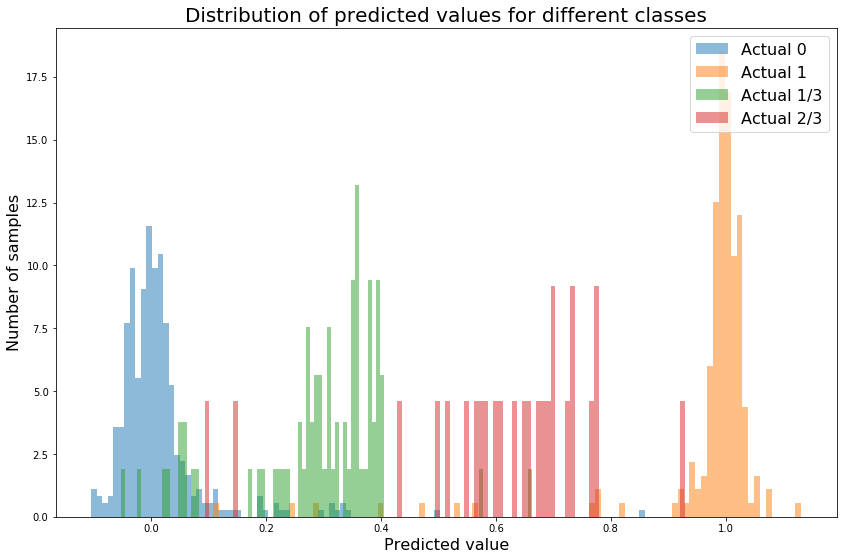

In [23]:
one_preds = eval_df[eval_df['prob'] == 1]['pred'].values
zero_preds = eval_df[eval_df['prob'] == 0]['pred'].values
third_preds = eval_df[eval_df['prob'] == 1/3]['pred'].values
twothird_preds = eval_df[eval_df['prob'] == 2/3]['pred'].values
plot_hist(zero_preds, one_preds, third_preds, twothird_preds)

### Distribution of predictions per binary label

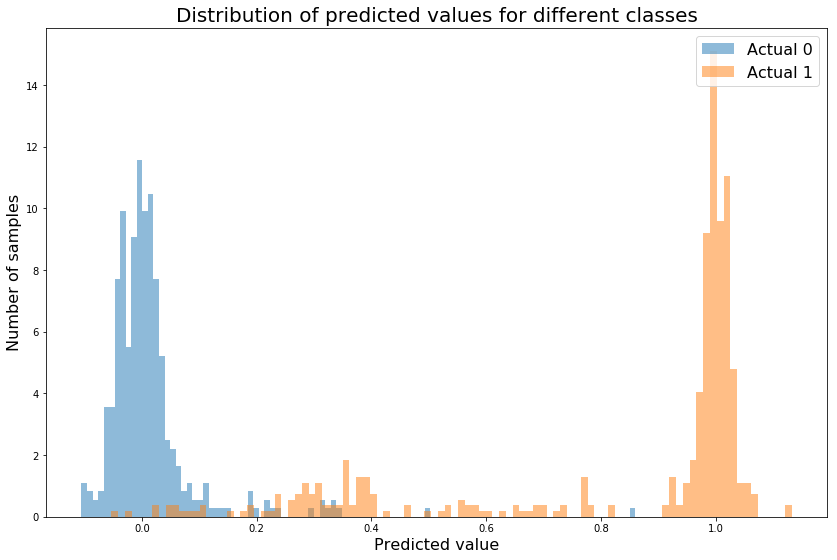

In [24]:
one_preds = eval_df[eval_df['prob_binary'] == 1]['pred'].values
zero_preds = eval_df[eval_df['prob_binary'] == 0]['pred'].values
plot_hist(zero_preds, one_preds)

### Worst misclassified samples

In [25]:
# Get random misclassified examples, given threshold as the classification threshold
def get_incorrect_predictions(df, true_class=1, n_samples=5, threshold=0.5):
    if true_class == 1:
        filtered = df[df['prob_binary'] == 1]
        filtered = filtered[filtered['pred'] < threshold]
    elif true_class == 0:
        filtered = df[df['prob_binary'] == 0]
        filtered = filtered[filtered['pred'] > threshold]
    num_samples = min(n_samples, filtered.shape[0])
    filtered = filtered.sample(n=num_samples)
    return filtered  

In [26]:
#false_neg.head()
eval_df.head()

,image,image_url,pred,prob,prob_binary
2238,<PIL.PngImagePlugin.PngImageFile image mode=RG...,images/cell0240.png,0.281165,0.333333,1
3173,<PIL.PngImagePlugin.PngImageFile image mode=RG...,images/cell0201.png,0.467938,1.000000,1
2110,<PIL.PngImagePlugin.PngImageFile image mode=RG...,images/cell2496.png,-0.011045,0.000000,0
2343,<PIL.PngImagePlugin.PngImageFile image mode=RG...,images/cell1495.png,0.050818,0.000000,0
2100,<PIL.PngImagePlugin.PngImageFile image mode=RG...,images/cell2357.png,0.039594,0.000000,0


### False negatives

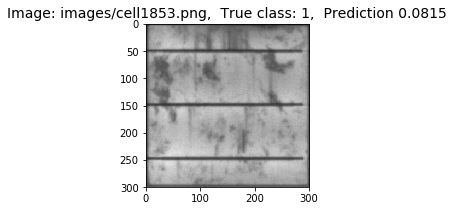

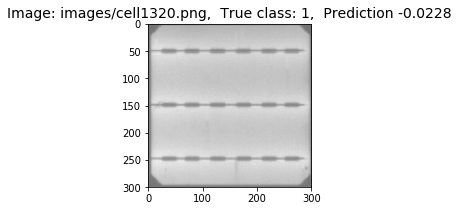

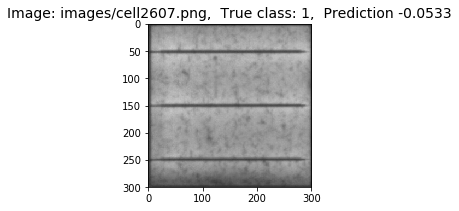

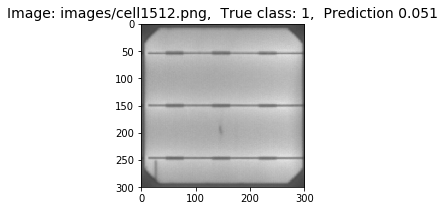

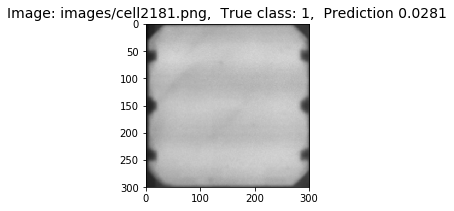

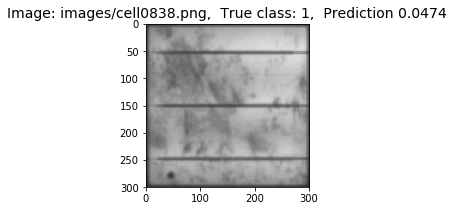

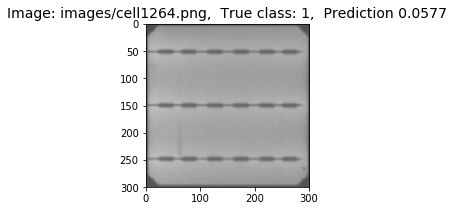

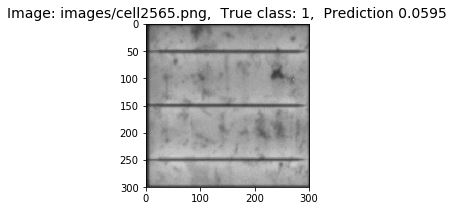

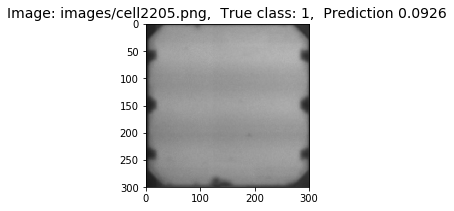

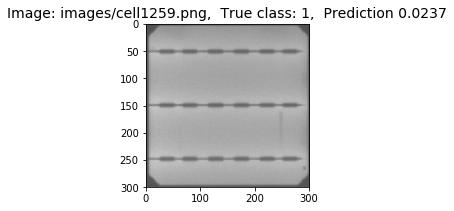

In [27]:
false_neg = get_incorrect_predictions(eval_df, true_class=1, n_samples=10, threshold=0.1)

for idx, row in false_neg.iterrows():
    f, ax = plt.subplots(1, 1, figsize = (3,3))
    plt.imshow(np.array(row["image"]))
    ax.set_title(f"Image: {row['image_url']},  True class: {row['prob_binary']},  Prediction {round(row['pred'], ndigits=4)}", fontsize=14)
    

### False positives

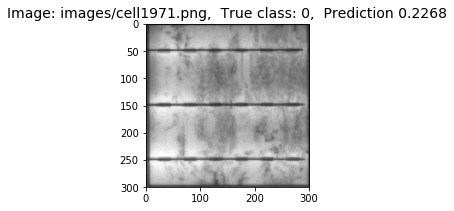

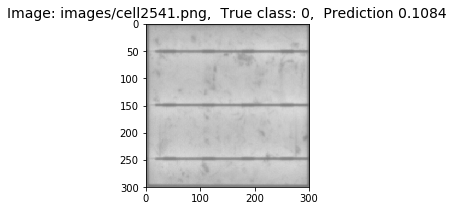

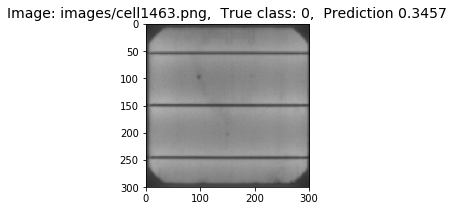

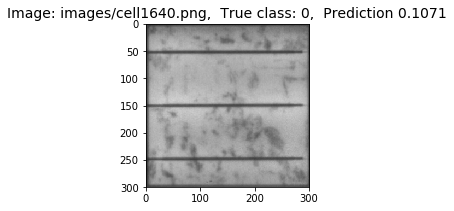

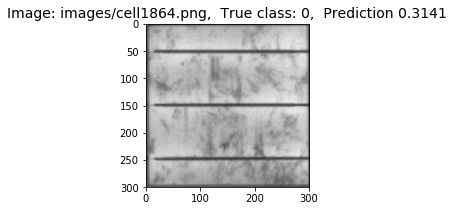

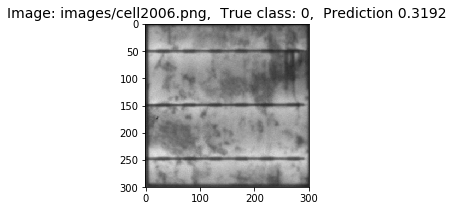

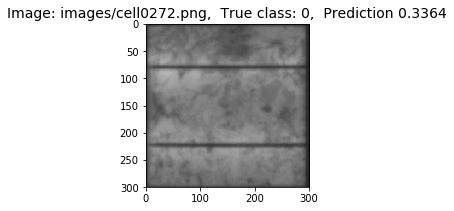

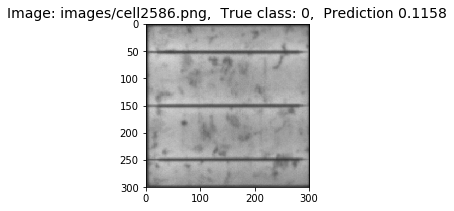

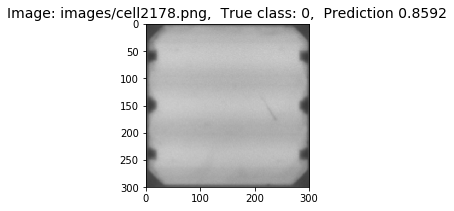

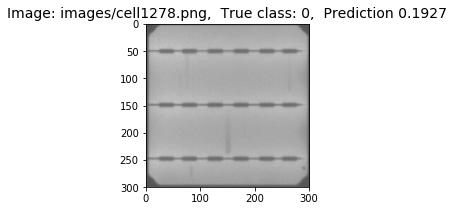

In [28]:
false_pos = get_incorrect_predictions(eval_df, true_class=0, n_samples=10, threshold=0.1)

for idx, row in false_pos.iterrows():
    f, ax = plt.subplots(1, 1, figsize = (3,3))
    #plt.imshow(np.array(Image.open(os.path.join(PATH, row["image"]))))
    plt.imshow(np.array(row["image"]))
    ax.set_title(f"Image: {row['image_url']},  True class: {row['prob_binary']},  Prediction {round(row['pred'], ndigits=4)}", fontsize=14)
    